# Instalação de Dependências

In [1]:
%pip install -r requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.0.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


# Informações
Rodadas: 14 com 2 turnos (mandantes diferentes nos jogos)
Por exemplo, se no primeiro turno DFC era o mandante contra TFC, no segundo TFC
Cada turno, está implícito que todos os times devem jogar entre si.

Para cada rodada será rodado o algoritmo de coloração com os times existentes.
As restrições serão de forma que, além daquelas descritas na especificação, se um time já jogou com o outro no mesmo turno então não podem jogar novamente (vizinhos).

Vou tentar colorir com o mínimo de cores possíveis. Se tem a mesma cor quer dizer que pode jogar junto.
Se cor > 


# Códigos Base

In [2]:
from typing import List, Tuple
from dataclasses import dataclass


# Significa que os times dentro desta tupla não
# podem ser mandantes na mesma rodada
@dataclass
class HostRestrict:
    hosts: Tuple[str, str]


# Esse jogo não pode acontencer nesta rodada.
# Atenção: O mandante importa.
@dataclass
class GameRestrict:
    host: str
    other: str


@dataclass
class Team:
    id: int
    name: str

In [19]:
import networkx as nx
import matplotlib.pyplot as plt

from typing import Mapping, List, Tuple


class Graph:
    def __init__(self, nodes: List[Team]):
        self._graph = nx.Graph()
        self._pos: Mapping = None

        # Número de vértices
        self.nodes = nodes
        self.edges: List[Tuple[Team, Team]] = []

        # Lista de adjacência
        self._neighbours = [[] for _ in nodes]

        self._draw_params = {
            "with_labels": True,
            "node_color": "skyblue",
            "node_size": 100,
            "edge_color": "gray",
            "font_weight": "bold",
            "font_size": 8,
        }

    def neighbours(self, v: Team) -> List[Team]:
        # Função auxiliadora para encontrar vizinhos de um vértice.
        # Subtraímos 1 pois a nossa lista começa em 0.
        return self._neighbours[v.id - 1]
    
    def insert_edge(self, v1: Team, v2: Team):
        self._graph.add_edge(v1.name, v2.name)
        self.edges.append((v1, v2))

        self.neighbours(v1).append(v2)
        self.neighbours(v2).append(v1)

    def has_edge(self, v1: Team, v2: Team):
        v2 in self.neighbours(v1)

    def node_degree(self, v: Team) -> int:
        return len(self.neighbours(v))

    def _reload_pos(self):
        self._pos = nx.spring_layout(self._graph)

    def _load_pos(self):
        if self._pos is None:
            self._reload_pos()

    def _create_view(self):
        self._load_pos()

        plt.figure(3, figsize=(12, 12))
        nx.draw(self._graph, pos=self._pos, alpha=0.9, **self._draw_params)

    def view(self):
        self._create_view()
        plt.title("Jogos")
        plt.show()

In [41]:
from typing import Dict, Set
import random
import copy


class Game:
    def __init__(self, teams: List[str], matches: int):
        self.teams = teams
        self.matches = matches

        self.matches_played: List[List[List[Team]]] = []

        self.host_restrictions: List[HostRestrict] = []
        self.game_restrictions: List[List[GameRestrict]] = [
            [] for _ in range(self.matches)
        ]

        self._teams_map: Dict[str, int] = {}
        self._load_teams_map()

    def _load_teams_map(self):
        for i, team in enumerate(self.teams):
            self._teams_map[team] = i

    def lookup_team(self, team: str) -> int:
        return self._teams_map[team]

    def ruler_teams(self) -> List[str]:
        ruler_teams: List[str] = []
        for team in self.teams:
            ruler_teams.append(f"M{team}")
        for team in self.teams:
            ruler_teams.append(f"N{team}")

        return ruler_teams

    def ruler_teams_full(self) -> List[str]:
        ruler_teams: List[str] = []
        for i, team in enumerate(self.teams):
            ruler_teams.append(Team(i, f"M{team}"))
        for i, team in enumerate(self.teams):
            ruler_teams.append(Team(i + len(self.teams), f"N{team}"))

        return ruler_teams

    def lookup_ruler_team(self, team: str, ruler: bool) -> Team:
        team_id = self.lookup_team(team)
        return (
            Team(team_id, f"M{team}")
            if ruler
            else Team(team_id + len(self.teams), f"N{team}")
        )

    def insert_host_restriction(self, hosts: Tuple[str, str]):
        self.host_restrictions.append(HostRestrict(hosts))

    def insert_game_restriction(self, matches: List[int], host: str, other: str):
        for match in matches:
            restrict = GameRestrict(host, other)
            if match > self.matches:
                restrict = GameRestrict(other, host)
                if match > self.matches * 2:
                    raise ValueError(f"O jogo tem apenas {self.matches} rodadas.")

                match = match - self.matches

            self.game_restrictions[match - 1].append(restrict)

    def build_graph(self):
        # Criar grafo com times duplicados
        # Teams terão inicial M para mandantes e N para não-mandantes.
        graph = Graph(self.ruler_teams_full())

        # Obviamente existirá uma restrição para mesmos times
        for team in self.teams:
            ruler, not_ruler = [self.lookup_ruler_team(team, b) for b in [True, False]]
            graph.insert_edge(ruler, not_ruler)

        # Além disso mandantes não podem fazer jogos com outros mandantes
        # E não-mandantes não podem fazer jogos com outros.
        for team1 in self.teams:
            mteam1 = self.lookup_ruler_team(team1, True)
            nteam1 = self.lookup_ruler_team(team1, False)

            for team2 in self.teams:
                mteam2 = self.lookup_ruler_team(team2, True)
                nteam2 = self.lookup_ruler_team(team2, False)

                graph.insert_edge(mteam1, mteam2)
                graph.insert_edge(nteam1, nteam2)

        for teams_match in self.matches_played:
            if len(teams_match) == 2:
                team1, team2 = teams_match

                graph.insert_edge(
                    self.lookup_ruler_team(team1, True),
                    self.lookup_ruler_team(team2, False),
                )

                graph.insert_edge(
                    self.lookup_ruler_team(team2, True),
                    self.lookup_ruler_team(team1, False),
                )

        match = len(self.matches_played)
        for restriction in self.game_restrictions[match - 1]:
            host = self.lookup_ruler_team(restriction.host, True)
            other = self.lookup_ruler_team(restriction.other, False)

            graph.insert_edge(host, other)

        for restriction in self.host_restrictions:
            first, second = restriction.hosts
            host_1 = self.lookup_ruler_team(first, True)
            host_2 = self.lookup_ruler_team(second, True)

            graph.insert_edge(host_1, host_2)

        return graph

    def min_color(self, colors: List[List[Team]], exclude: Set[int]) -> int:
        min_id, min_color = None, None
        for i, color in enumerate(colors):
            if i in exclude or len(color) >= 2:
                continue

            if min_color is None or len(color) < min_color:
                min_id = i
                min_color = len(color)

        return min_id
    
    def select_order(self) -> List[str]:
        # Talvez eu possa substituir isso por criar uma ligação com ele mesmo

        teams_copy = set(self.teams)
        team_order: List[str] = []
        for match in self.matches_played[::-1]:
            for teams in match:
                if len(teams) == 1:
                    team = teams[0].name[1:]
                    teams_copy.discard(team)
                    team_order.append(team)
                    break
        
        return team_order + random.sample(list(teams_copy), len(teams_copy))

    def color_graph(self, graph: Graph) -> List[List[Team]]:
        colors: List[List[Team]] = []
        color_map: List[Team] = [None for _ in graph.nodes]

        chosen_teams: Set[str] = set()

        ruler = True
        for team in self.select_order():
            if team in chosen_teams:
                continue

            v = self.lookup_ruler_team(team, ruler)

            exclude = set()
            for neighbour in graph.neighbours(v):
                if color_map[neighbour.id] is not None:
                    exclude.add(color_map[neighbour.id])

            color = self.min_color(colors, exclude)
            if color is None:
                color_map[v.id] = len(colors)
                colors.append([v])
            else:
                color_map[v.id] = color
                colors[color].append(v)

            ruler = not ruler
            chosen_teams.add(team)

            # if ruler:
            #     for restriction in self.host_restrictions:
            #         other = None
            #         if team == restriction.hosts[0]:
            #             other = restriction.hosts[1]
            #         elif team == restriction.hosts[1]:
            #             other = restriction.hosts[0]
                    
            #         if other is not None:
            #             first2 = self.lookup_ruler_team(other, True)
            #             for team in self.teams:
            #                 second2 = self.lookup_ruler_team(team, False)
            #                 graph.insert_edge(first2, second2)

        return colors
    
    def print_colors(self, match: int, colors: List[List[Team]]):
        matches = []
        excluded = []
        for teams in colors:
            if len(teams) == 1:
                excluded.append(teams[0].name[1:])
            else:
                matches.append("x".join([team.name[1:] for team in teams]))

        print(f"Matches #{match}: {' | '.join(matches)}")
        print(f"Excluded in Match #{match}: {', '.join(excluded)}")

    def restart_game(self):
        self.matches_played = []

    def play_match(self) -> List[Tuple[int]]:
        graph = self.build_graph()
        colors = self.color_graph(graph)
        self.print_colors(len(self.matches_played)+1, colors)
        self.matches_played.append(colors)

In [42]:
times, matches = ["DFC", "TFC", "AFC", "LFC", "FFC", "OFC", "CFC"], 7
game = Game(times, matches)

game.insert_game_restriction([1, 14], "DFC", "CFC")

game.insert_host_restriction(("TFC", "OFC"))
game.insert_host_restriction(("AFC", "FFC"))

game.insert_game_restriction([7, 13], "LFC", "FFC")
game.insert_game_restriction([10, 11], "OFC", "LFC")
game.insert_game_restriction([12, 13], "AFC", "FFC")
game.insert_game_restriction([2, 3], "CFC", "TFC")

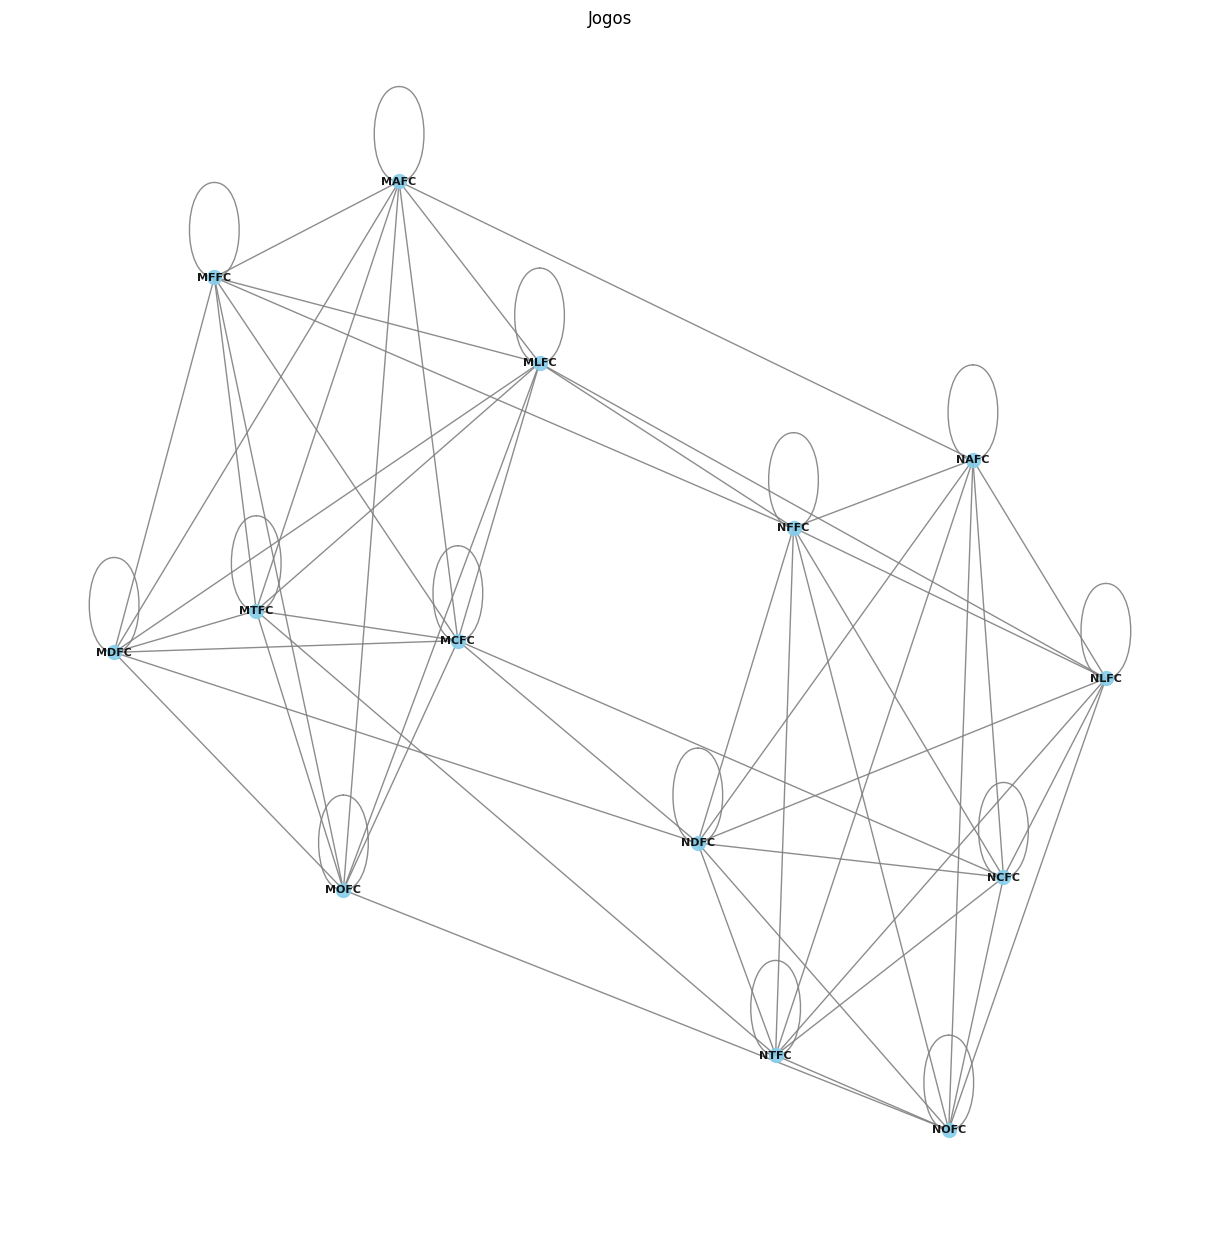

In [43]:
graph = game.build_graph()
graph.view()

- 1: DFCxCFC
- 2: CFCxTFC
- 3: CFCxTFC, LFCxOFC
- 4: LFCxOFC
- 5: FFCxAFC
- 6: FFCxAFC, FFCxLFC
- 7: CFCxDFC

DFCxCFC - Não 1
CFCxDFC - Não 7

LFCxFFC - Não 7
FFCxLFC - Não 6

LFCxOFC - Não 3
LFCxOFC - Não 4

FFCxAFC - Não 5
FFCxAFC - Não 6

CFCxTFC - Não 2
CFCxTFC - Não 3

In [46]:
game.restart_game()
game.play_match()
game.play_match()
game.play_match()
game.play_match()
game.play_match()
game.play_match()
game.play_match()

Matches #1: AFCxFFC | OFCxDFC | LFCxTFC
Excluded in Match #1: CFC
Matches #2: CFCxLFC | OFCxTFC | AFCxFFC
Excluded in Match #2: DFC
Matches #3: DFCxCFC | TFCxFFC | LFCxAFC
Excluded in Match #3: OFC
Matches #4: OFCxDFC | CFCxFFC | AFCxLFC
Excluded in Match #4: TFC
Matches #5: TFCxOFC | DFCxCFC | LFCxAFC
Excluded in Match #5: FFC
Matches #6: FFCxTFC | OFCxDFC | CFCxAFC
Excluded in Match #6: LFC
Matches #7: LFCxFFC | TFCxOFC | DFCxCFC
Excluded in Match #7: AFC
